In [1]:
!pip install pysmatch==2.0


In [2]:
import pandas as pd
import numpy as np
from pysmatch.Matcher import Matcher # Assuming Matcher.py is in pysmatch directory
import warnings

In [3]:
# --- 0. Suppress Warnings (Optional) ---

warnings.filterwarnings('ignore')

In [5]:
# --- 1. Load and Prepare Data ---
# Load loan.csv data as per user's request
path = "/misc/loan.csv" # Ensure this path is correct or the file is in the same directory
try:
    data = pd.read_csv(path)
except FileNotFoundError:
    print(f"Error: Data file '{path}' not found. Please ensure the path is correct.")
    exit()
data

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,loan_status
0,16000,16000,16000.0,36 months,18.85,585.29,D,D3,Fully Paid
1,14000,14000,14000.0,36 months,12.42,467.82,B,B4,Fully Paid
2,7200,7200,7200.0,36 months,8.99,228.93,B,B1,Fully Paid
3,19200,19200,19200.0,36 months,16.99,684.44,D,D1,Fully Paid
4,6000,6000,6000.0,36 months,12.12,199.63,B,B3,Fully Paid
...,...,...,...,...,...,...,...,...,...
21995,20000,20000,20000.0,36 months,13.58,679.48,C,C2,Default
21996,9600,9600,9600.0,36 months,25.69,385.21,F,F1,Default
21997,10000,10000,10000.0,36 months,13.49,339.31,C,C2,Default
21998,4000,4000,4000.0,36 months,18.06,144.74,D,D2,Default


In [6]:
# Create test and control groups based on 'loan_status'
# Ensure 'loan_status' column exists in your DataFrame
if 'loan_status' not in data.columns:
    print(f"Error: Column 'loan_status' not found in {path}.")
    exit()

test_data_full = data[data.loan_status == "Default"].copy() # Use .copy() to avoid SettingWithCopyWarning
control_data_full = data[data.loan_status == "Fully Paid"].copy()

In [8]:

# Check if test_data_full and control_data_full are empty
if test_data_full.empty:
    print("Warning: No test data found for 'Default' status. Please check your data and filter conditions.")
if control_data_full.empty:
    print("Warning: No control data found for 'Fully Paid' status. Please check your data and filter conditions.")

# Matcher will handle the creation of the treatment variable (yvar) internally
# based on the test and control DataFrames passed to it.
print("--- Sample Test Data (from loan.csv) ---")
print(test_data_full.head())
print("\n--- Sample Control Data (from loan.csv) ---")
print(control_data_full.head())

--- Sample Test Data (from loan.csv) ---
       loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
20000      12000        12000          12000.0   60 months     12.59   
20001      15000        15000          15000.0   36 months     10.75   
20002      30000        30000          30000.0   36 months      6.49   
20003       7500         7500           7500.0   36 months     16.14   
20004      26125        26125          26125.0   36 months     14.03   

       installment grade sub_grade loan_status  
20000       270.53     C        C2     Default  
20001       489.31     B        B4     Default  
20002       919.34     A        A2     Default  
20003       264.20     C        C4     Default  
20004       893.28     C        C2     Default  

--- Sample Control Data (from loan.csv) ---
   loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment  \
0      16000        16000          16000.0   36 months     18.85       585.29   
1      14000        14000

In [9]:

# --- 2. Initialize Matcher ---
# Define the treatment variable name (Matcher will create this column)
treatment_var = 'is_default' # Any descriptive name; Matcher will use this as the column name

# Define covariates for matching.
# Select suitable columns from loan.csv as covariates.
# E.g., "loan_amnt", "funded_amnt", "int_rate", "installment", "grade"
# Columns like 'record_id', 'scores', 'match_id', 'weight' are handled by Matcher's exclude logic.
# Ensure no NA values in these covariates in your real data, or handle them before passing.
# Matcher also has internal NA handling for xvars.

# Exclude the original 'loan_status' string column as we use 'is_default' as the treatment indicator.
# You can add other ID-like columns or columns unsuitable as covariates to exclude_cols.
exclude_cols = ['loan_status']

matcher_instance = Matcher(test=test_data_full,
                           control=control_data_full,
                           yvar=treatment_var, # Matcher will create 'is_default' column internally
                           exclude=exclude_cols)

print(f"\n--- Matcher Initialized ---")
print(f"Treatment Column: {matcher_instance.treatment_col}")
print(f"Covariates (xvars) selected by Matcher: {matcher_instance.xvars}")
print(f"Initial data shape in Matcher: {matcher_instance.data.shape}")
print(f"Test group size in Matcher: {matcher_instance.testn}, Control group size in Matcher: {matcher_instance.controln}")


--- Matcher Initialized ---
Treatment Column: is_default
Covariates (xvars) selected by Matcher: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade']
Initial data shape in Matcher: (22000, 11)
Test group size in Matcher: 2000, Control group size in Matcher: 20000


In [10]:

# --- 3. Fit Propensity Score Model(s) ---
# Available model_type options: 'linear' (Logistic Regression), 'knn' (K-Nearest Neighbors), 'tree' (CatBoost).
# nmodels is recommended to be adjusted based on the sample size of the minority class.
# Using n_jobs > 1 for parallel processing if your machine has multiple cores.
if matcher_instance.testn > 0 and matcher_instance.controln > 0: # Ensure there's data to fit on
    matcher_instance.fit_scores(balance=True, nmodels=10, model_type='linear', n_jobs=2)
    # Example with another model type:
    # matcher_instance.fit_scores(balance=True, nmodels=5, model_type='tree', n_jobs=2) # Using CatBoost
    # Example with Optuna for hyperparameter tuning:
    # matcher_instance.fit_scores(balance=True, model_type='tree', use_optuna=True, n_trials=20, n_jobs=2)

    print("\n--- Propensity Score Models Fitted ---")
    if matcher_instance.models:
        print(f"Number of models fitted: {len(matcher_instance.models)}")
        if matcher_instance.model_accuracy:
            print(f"Average model accuracy: {np.mean(matcher_instance.model_accuracy):.4f}")
        else:
            print("Model accuracy not available.")
    else:
        print("No models were fitted (possibly due to data issues).")
else:
    print("\n--- Skipping Propensity Score Model Fitting (No test or control data in Matcher) ---")



--- Propensity Score Models Fitted ---
Number of models fitted: 10
Average model accuracy: 0.6645


In [11]:

# --- 4. Predict Propensity Scores ---
if matcher_instance.models: # Only predict if models were fitted
    matcher_instance.predict_scores()
    print("\n--- Propensity Scores Predicted ---")
    if 'scores' in matcher_instance.data.columns:
        print("Scores column added to internal data:")
        print(matcher_instance.data[['record_id', matcher_instance.treatment_col, 'scores']].head())
    else:
        print("Scores column not found after prediction.")
else:
    print("\n--- Skipping Propensity Score Prediction (No models fitted) ---")




--- Propensity Scores Predicted ---
Scores column added to internal data:
   record_id  is_default    scores
0          0           1  0.566657
1          1           1  0.338375
2          2           1  0.231389
3          3           1  0.609207
4          4           1  0.633253



--- Plotting Score Distributions (Before Matching) ---


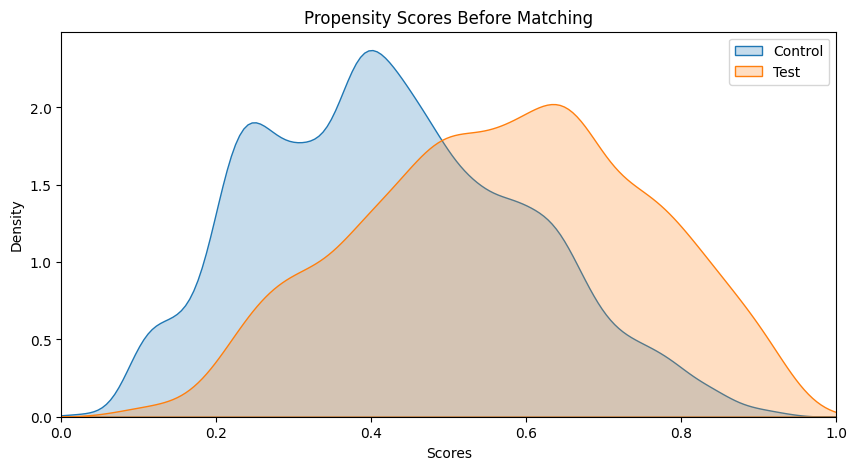


--- Tuning Threshold (Example) ---


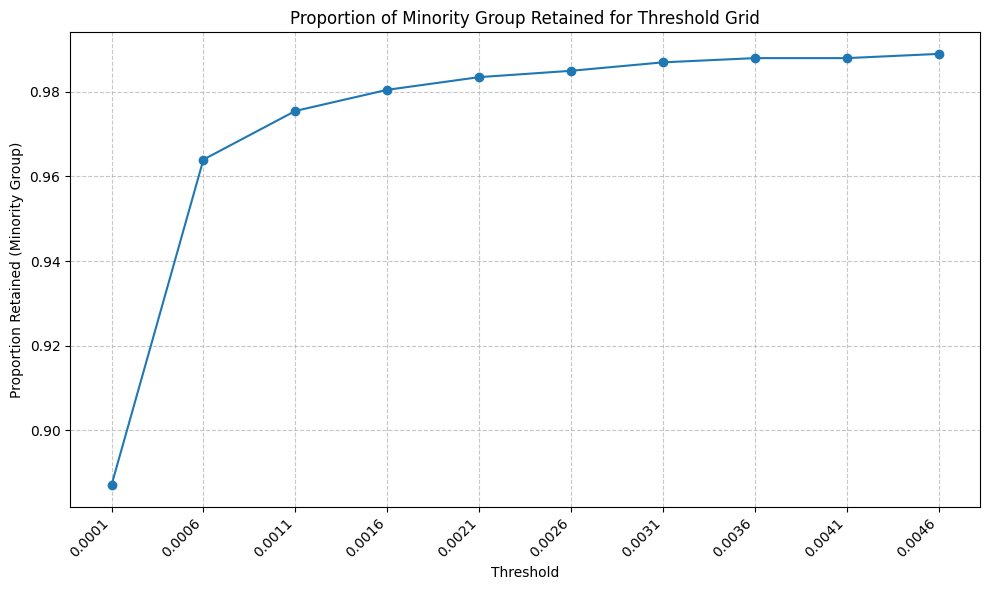

In [12]:

# --- 5. Plot Score Distributions (Before Matching) ---
if 'scores' in matcher_instance.data.columns:
    print("\n--- Plotting Score Distributions (Before Matching) ---")
    matcher_instance.plot_scores() # This will show a plot
else:
    print("\n--- Skipping Score Distribution Plot (Scores not available) ---")

# --- 6. Tune Threshold (Optional) ---
# This helps decide a good threshold value by seeing retention rates.
if 'scores' in matcher_instance.data.columns:
    print("\n--- Tuning Threshold (Example) ---")
    try:
        # Ensure the tune_threshold function in the matching module is working correctly.
        matcher_instance.tune_threshold(method='min', nmatches=1, rng=np.arange(0.0001, 0.0051, 0.0005))
    except Exception as e:
        print(f"Could not run tune_threshold: {e}")
else:
    print("\n--- Skipping Threshold Tuning (Scores not available) ---")




--- Performing Standard Matching (exhaustive_matching=False, replacement=True) ---
Standard matching (with replacement) complete. Matched data shape: (3984, 13)
Sample of standard matched data:
   record_id  is_default    scores  match_id
0       1945           1  0.093729         0
1        277           1  0.095388         1
2         31           1  0.102288         2
3        198           1  0.104989         3
4        540           1  0.105903         4

--- Performing Exhaustive Matching (exhaustive_matching=True) ---


Exhaustive Matching: 100%|██████████| 2000/2000 [00:06<00:00, 289.61it/s]


Exhaustive matching complete. Matched data shape: (3984, 15)
Sample of exhaustive matched data (long format):
   record_id  is_default    scores  match_id matched_as  pair_score_diff
0          0           1  0.566657         0       case         0.000009
1      21990           0  0.566666         0    control         0.000009
2          1           1  0.338375         1       case         0.000000
3       2288           0  0.338375         1    control         0.000000
4          2           1  0.231389         2       case         0.000029

--- Plotting Matched Score Distributions (Exhaustive) ---


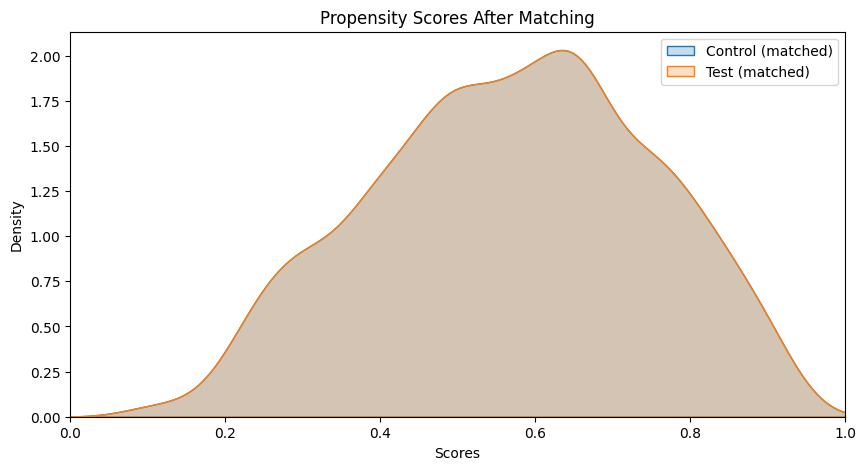


--- Record Frequency (Controls in Exhaustive Matched Data) ---
   record_id  n_occurrences_as_control
0      20729                         6
1       7395                         6
2      12066                         6
3      12174                         4
4      15360                         4

--- Assigning Weights (Exhaustive Matched Data) ---
Weights assigned. Sample:
   record_id  match_id  weight matched_as
0          0         0     1.0       case
1      21990         0     1.0    control
2          1         1     1.0       case
3       2288         1     1.0    control
4          2         2     1.0       case

--- Comparing Continuous Variables (Exhaustive Matched Data) ---


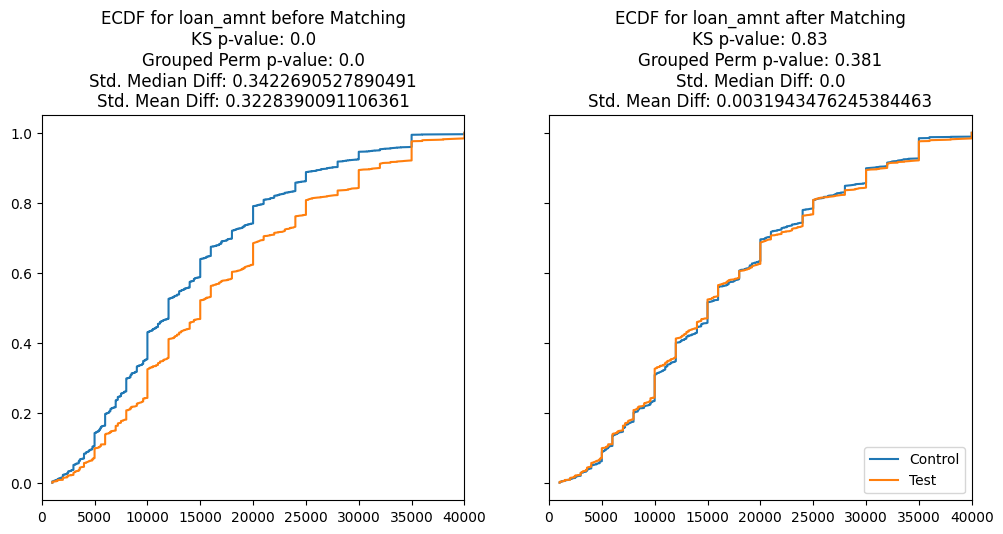

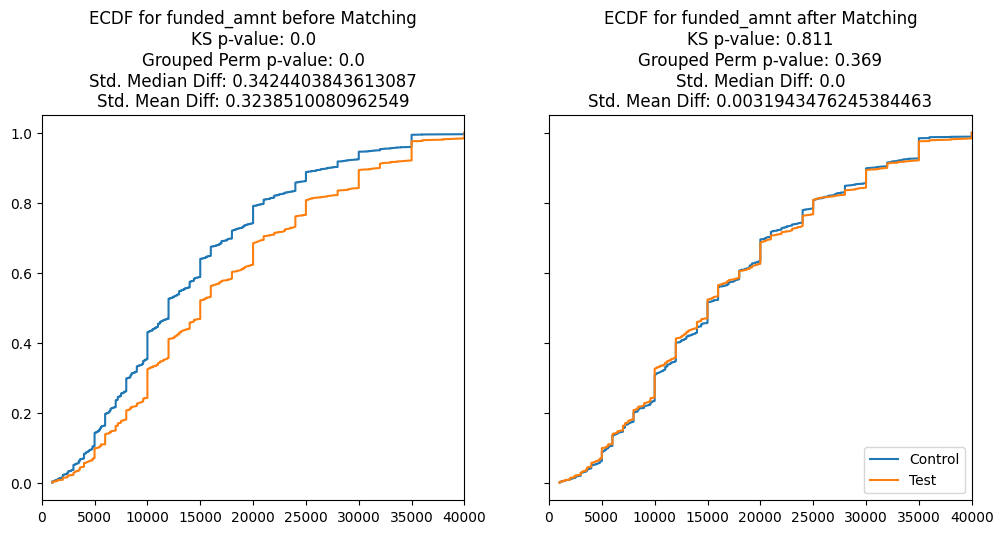

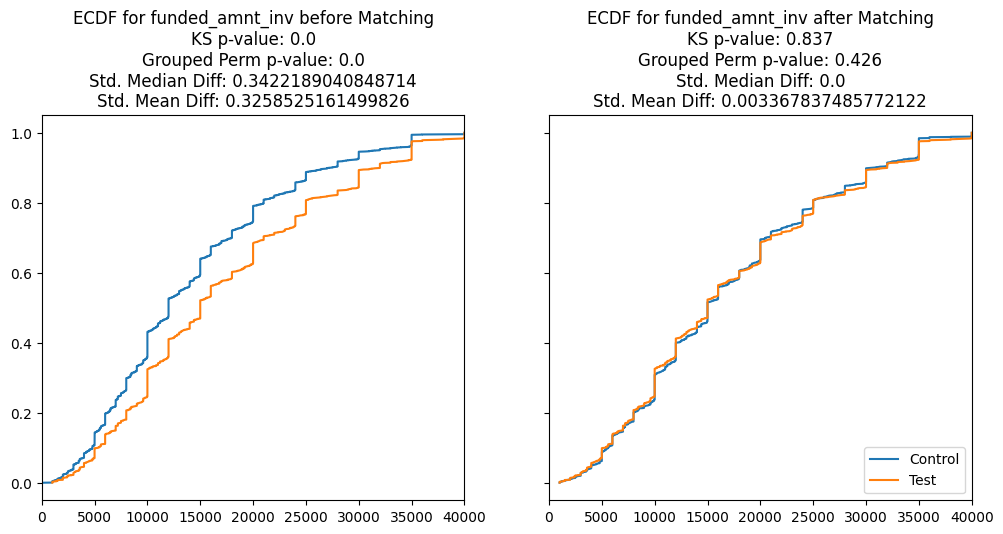

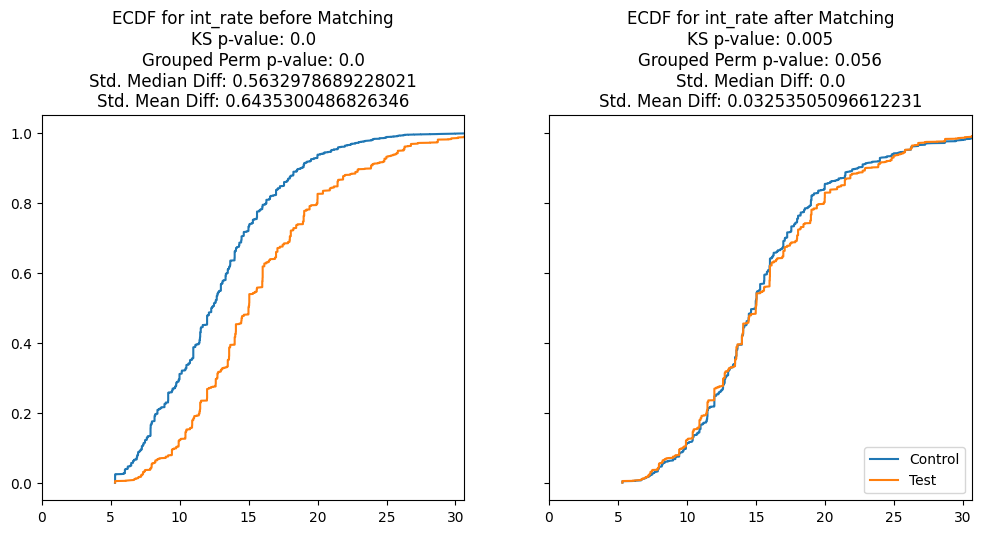

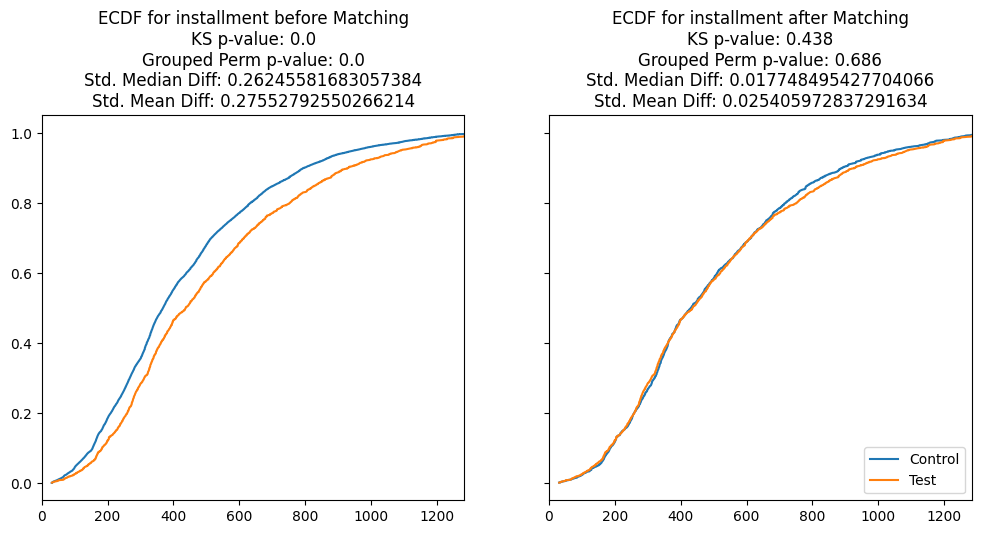

Continuous variables comparison table:
               var  ks_before  ks_after  grouped_chisqr_before  \
0        loan_amnt        0.0     0.830                    0.0   
1      funded_amnt        0.0     0.811                    0.0   
2  funded_amnt_inv        0.0     0.837                    0.0   
3         int_rate        0.0     0.005                    0.0   
4      installment        0.0     0.438                    0.0   

   grouped_chisqr_after  std_median_diff_before  std_median_diff_after  \
0                 0.381                0.342269               0.000000   
1                 0.369                0.342440               0.000000   
2                 0.426                0.342219               0.000000   
3                 0.056                0.563298               0.000000   
4                 0.686                0.262456               0.017748   

   std_mean_diff_before  std_mean_diff_after  
0              0.322839             0.003194  
1              0.323851  

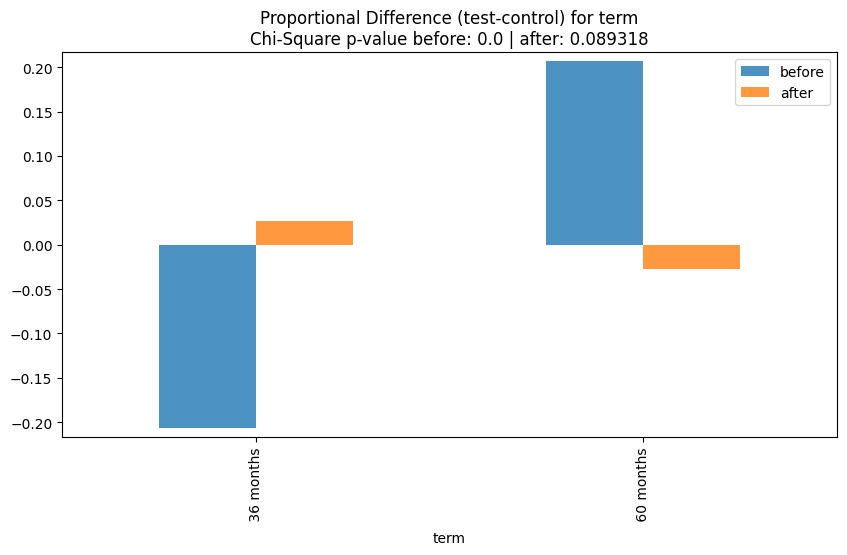

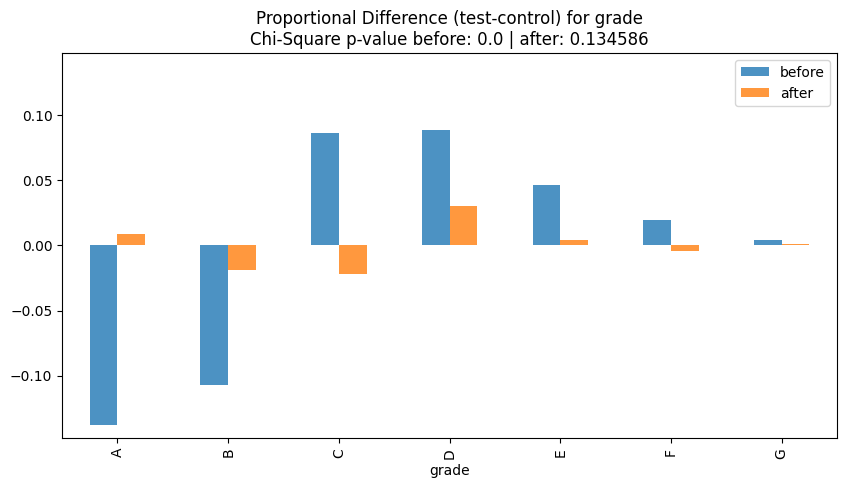

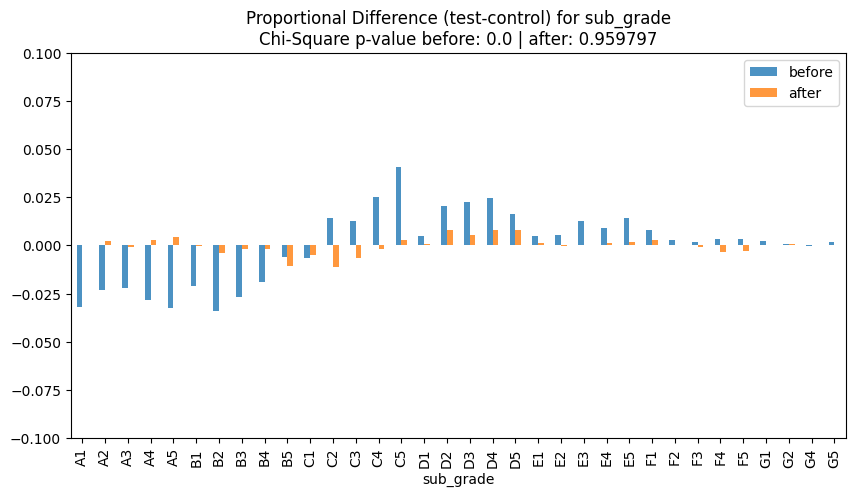

Categorical variables comparison table:
         var  before     after
0       term     0.0  0.089318
1      grade     0.0  0.134586
2  sub_grade     0.0  0.959797

--- Example Script Finished ---


In [13]:

# --- 7. Perform Matching ---
# The match method offers flexibility:
# - Standard matching: `exhaustive_matching=False` (default).
#   - `method`: 'min', 'random', 'nn' (if implemented in pysmatch.matching).
#   - `replacement`: True or False.
# - Exhaustive matching: `exhaustive_matching=True`.
#   - `method` and `replacement` parameters are ignored for exhaustive matching as its logic is internal.

if 'scores' in matcher_instance.data.columns: # Ensure scores are available for matching
    # Example 7a: Standard Matching with replacement
    print("\n--- Performing Standard Matching (exhaustive_matching=False, replacement=True) ---")
    matcher_instance.match(threshold=0.001, nmatches=1, method='min', replacement=True, exhaustive_matching=False)
    if not matcher_instance.matched_data.empty:
        print(f"Standard matching (with replacement) complete. Matched data shape: {matcher_instance.matched_data.shape}")
        print("Sample of standard matched data:")
        display_cols_standard = ['record_id', matcher_instance.treatment_col, 'scores']
        if 'match_id' in matcher_instance.matched_data.columns: # 'match_id' might be named differently by external func
            display_cols_standard.append('match_id')
        if 'weight' in matcher_instance.matched_data.columns: # Weights are often added after matching with replacement
            display_cols_standard.append('weight')
        print(matcher_instance.matched_data[display_cols_standard].head())
    else:
        print("No matches found with standard matching (with replacement).")

    # Example 7b: Exhaustive Matching
    print("\n--- Performing Exhaustive Matching (exhaustive_matching=True) ---")
    # For exhaustive matching, 'method' and 'replacement' are handled internally by the new logic.
    # You can set exhaustive_matching_default=True in __init__ or exhaustive_matching=True in match() call.

    # Re-matching on the same instance (matched_data will be overwritten)
    # Or, create a new Matcher instance if you want to keep the previous standard match results.
    matcher_instance.match(threshold=0.001, nmatches=1, exhaustive_matching=True) # Requesting 1 match per test unit

    if not matcher_instance.matched_data.empty:
        print(f"Exhaustive matching complete. Matched data shape: {matcher_instance.matched_data.shape}")
        print("Sample of exhaustive matched data (long format):")
        # Columns from exhaustive matching: record_id, match_id, matched_as, pair_score_diff, and original data
        display_cols_exhaustive = ['record_id', matcher_instance.treatment_col, 'scores', 'match_id', 'matched_as', 'pair_score_diff']
        actual_display_cols_exhaustive = [col for col in display_cols_exhaustive if col in matcher_instance.matched_data.columns]
        print(matcher_instance.matched_data[actual_display_cols_exhaustive].head())

        # --- 8. Plot Matched Score Distributions (after Exhaustive Matching) ---
        print("\n--- Plotting Matched Score Distributions (Exhaustive) ---")
        matcher_instance.plot_matched_scores() # This will show a plot

        # --- 9. Record Frequency and Weighting (Example with Exhaustive Matched Data) ---
        print("\n--- Record Frequency (Controls in Exhaustive Matched Data) ---")
        # This shows how many times each original control record was used
        control_usage_freq = matcher_instance.record_frequency()
        print(control_usage_freq.head())

        print("\n--- Assigning Weights (Exhaustive Matched Data) ---")
        matcher_instance.assign_weight_vector()
        if 'weight' in matcher_instance.matched_data.columns:
            print("Weights assigned. Sample:")
            weight_display_cols = ['record_id', 'match_id', 'weight']
            if 'matched_as' in matcher_instance.matched_data.columns:
                weight_display_cols.append('matched_as')
            actual_weight_display_cols = [col for col in weight_display_cols if col in matcher_instance.matched_data.columns]
            print(matcher_instance.matched_data[actual_weight_display_cols].head())
        else:
            print("Weight column not found after assignment.")

        # --- 10. Covariate Balance Assessment (Example with Exhaustive Matched Data) ---
        # Ensure visualization.compare_continuous and compare_categorical are implemented
        # and that the Matcher instance has the necessary attributes (self.test, self.control, self.yvar)
        print("\n--- Comparing Continuous Variables (Exhaustive Matched Data) ---")
        try:
            continuous_comparison = matcher_instance.compare_continuous(return_table=True, plot_result=True)
            if continuous_comparison is not None and not continuous_comparison.empty:
                print("Continuous variables comparison table:")
                print(continuous_comparison)
            elif continuous_comparison is not None and continuous_comparison.empty:
                print("Continuous variables comparison table is empty (no continuous xvars or other issue).")
            else:
                print("Continuous variables comparison returned None.")
        except Exception as e:
            print(f"Could not compare continuous variables: {e}")


        print("\n--- Comparing Categorical Variables (Exhaustive Matched Data) ---")
        # Example: 'grade' is a categorical variable in loan.csv data
        # prop_test is for individual categorical variables.
        # compare_categorical would ideally iterate through them.
        if 'grade' in matcher_instance.xvars: # Assuming 'grade' was selected as a covariate
            grade_prop_test = matcher_instance.prop_test('grade')
            if grade_prop_test:
                print("Prop_test results for 'grade':")
                print(grade_prop_test)
            else:
                print("Prop_test for 'grade' did not return results (e.g., not detected as categorical, excluded, or data issue).")
        else:
            print("'grade' not in selected covariates (xvars), skipping its prop_test.")

        try:
            categorical_comparison = matcher_instance.compare_categorical(return_table=True, plot_result=True)
            if categorical_comparison is not None and not categorical_comparison.empty:
                print("Categorical variables comparison table:")
                print(categorical_comparison)
            elif categorical_comparison is not None and categorical_comparison.empty:
                print("Categorical variables comparison table is empty (no categorical xvars or other issue).")
            else:
                print("Categorical variables comparison returned None.")
        except Exception as e:
            print(f"Could not compare categorical variables: {e}")
    else:
        print("No matches found with exhaustive matching, skipping further analysis steps.")
else:
    print("\n--- Skipping Matching and Further Analysis (Scores not available or no test/control data) ---")

print("\n--- Example Script Finished ---")